# Coronal Loop Scaling Laws

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from scipy.special import betaincinv,beta
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize,SqrtStretch,AsinhStretch
from sunpy.coordinates import HeliographicStonyhurst, Helioprojective
from sunpy.map import Map

import synthesizAR.extrapolate
from synthesizAR.physics import MartensScalingLaws
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

Experiment with creating functions for RTV and Martens scaling laws

## RTV

## Martens
The Martens scaling laws can be written as,

$$
T(s) = T_{max}[\beta_r^{-1}(s/L; \lambda+1, 1/2)]^{\frac{1}{2+\gamma+\alpha}} \\
P_0L = T_{max}^{\frac{11+2\gamma}{4}}\left(\frac{\kappa_0}{\chi_0}\right)^{1/2}\frac{(3-2\gamma)^{1/2}}{4+2\gamma+2\alpha}B(\lambda+1,1/2)
$$

where the loop is assumed to be isobaric and the density can be determined by the closure condition $P=2k_BnT$. Additionally, we assume symmetry about the apex and compute solutions for half of a loop. A few more terms defined,

* $\alpha$: temperature dependence in the heating function
* $\gamma$: temperature dependence in the radiative loss function
* $\chi_0=\chi/4k_B^2$
* $\lambda=\frac{1-2\nu+\mu}{2(\nu-\mu)}$
* $\mu=-2(2+\gamma)/7$
* $\nu=2\alpha/7$

So the main job is computing the Beta function $B$ and the inverse of the regularized incomplete Beta function $\beta_r^{-1}$

In [ ]:
@u.quantity_input
def martens_t(T_max:u.K, s:u.cm, loop_length:u.cm, alpha=0, gamma=0.5)->u.K:
    lam = martens_lambda(alpha,gamma)
    x = (s/loop_length).decompose().value
    exp = 1./(2+gamma+alpha)
    return T_max*(betaincinv(lam+1,0.5,x)**exp) + 0.01*u.MK

@u.quantity_input
def martens_n(Tmax, s, loop_length, alpha=0, gamma=0.5):
    kappa_0 = 1e-6
    chi_0 = (10**(-18.8))/(4.*const.k_B.cgs.value**2)
    lam = martens_lambda(alpha,gamma)
    p0 = Tmax**((11+2*gamma)/4) * np.sqrt(kappa_0/chi_0) * np.sqrt(3-2*gamma)/(4+2*gamma+2*alpha) * beta(lam+1,0.5)/loop_length
    T = martens_t(Tmax, s, loop_length, alpha=alpha, gamma=gamma)
    return p0/2/const.k_B.cgs.value/T

def martens_lambda(alpha,gamma):
    mu = -2*(2+gamma)/7
    nu = 2*alpha/7
    return (1.-2*nu + mu)/(2*(nu-mu))

In [3]:
loop_length = 8e9*u.cm
s = np.linspace(0,loop_length,1000)
Tmax = 1e6*u.K

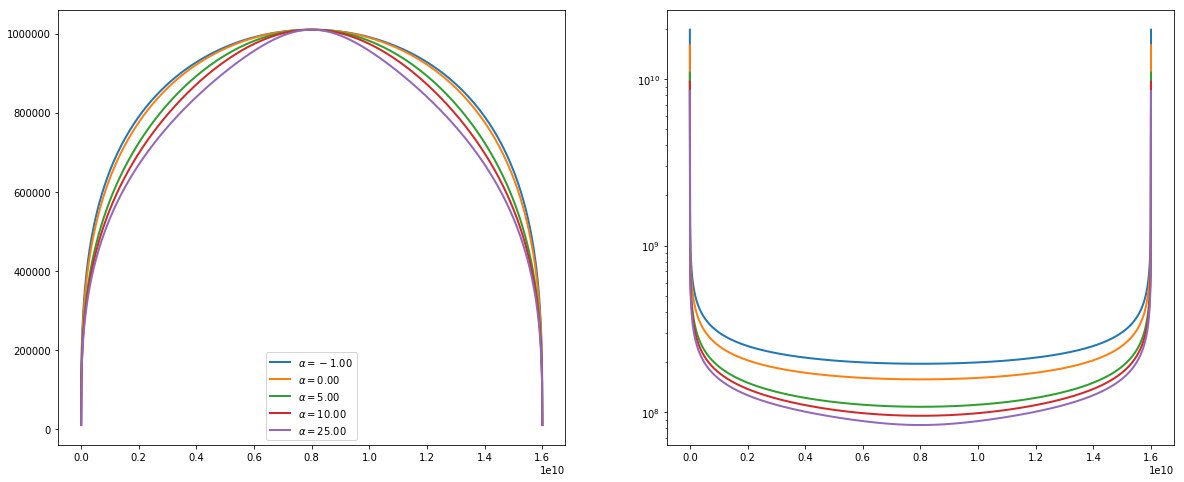

In [7]:
fig,axes = plt.subplots(1,2,figsize=(20,8),sharex=True)
for i,a in enumerate([-1,0,5,10, 25]):
    ms = MartensScalingLaws(s, loop_length, Tmax, alpha=a, gamma=0.5,)
    s_new = ms.s
    s_new = u.Quantity(np.concatenate([s_new.value,(s_new[-1]+s_new[1:]).value]),s_new.unit)
    t = ms.temperature
    t = u.Quantity(np.concatenate([t.value, t[:-1][::-1].value]),t.unit)
    n = ms.density
    n = u.Quantity(np.concatenate([n.value,n[:-1][::-1].value]),n.unit)
    axes[0].plot(s_new, t, color=f'C{i}',ls='-',lw=2,label=f'$\\alpha={a:.2f}$')
    axes[1].plot(s_new, n, color=f'C{i}',ls='-',lw=2)
axes[0].legend()
axes[1].set_yscale('log')
#plt.ylim(0,Tmax)
#plt.xlim(0,loop_length)

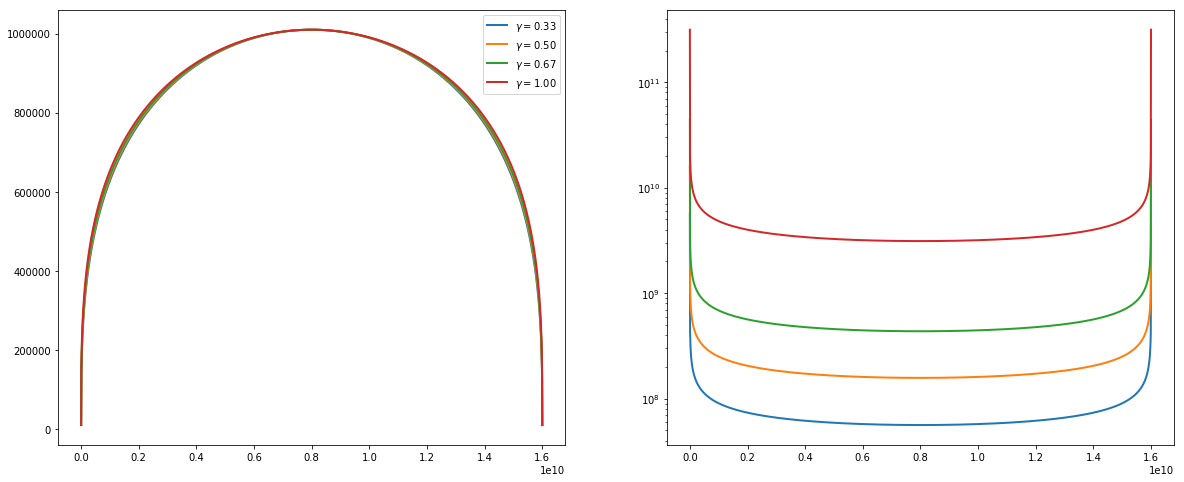

In [9]:
fig,axes = plt.subplots(1,2,figsize=(20,8),sharex=True)
for i,g in enumerate([0.33333,0.5,0.66666667,1]):
    ms = MartensScalingLaws(s, loop_length, Tmax, alpha=0, gamma=g,)
    s_new = ms.s
    s_new = u.Quantity(np.concatenate([s_new.value,(s_new[-1]+s_new[1:]).value]),s_new.unit)
    t = ms.temperature
    t = u.Quantity(np.concatenate([t.value, t[:-1][::-1].value]),t.unit)
    n = ms.density
    n = u.Quantity(np.concatenate([n.value,n[:-1][::-1].value]),n.unit)
    axes[0].plot(s_new, t, color=f'C{i}',ls='-',lw=2,label=f'$\gamma={g:.2f}$')
    axes[1].plot(s_new, n, color=f'C{i}',ls='-',lw=2)
axes[0].legend()
axes[1].set_yscale('log')
#plt.ylim(0,Tmax)
#plt.xlim(0,loop_length)

## Application to Synthetic AR Modeling

In [202]:
shape = [ 150, 150] * u.pixel
obs = SkyCoord(lon=0.*u.deg,lat=0.*u.deg,radius=const.au,frame=HeliographicStonyhurst)
blc = SkyCoord(-100 * u.arcsec, -100 * u.arcsec,frame=Helioprojective(observer=obs))
trc = SkyCoord(100 * u.arcsec, 100 * u.arcsec, frame=Helioprojective(observer=obs))
centers = SkyCoord([15, -15,]*u.arcsec,[0, 0,]*u.arcsec,frame=Helioprojective(observer=obs))
sigmas = u.Quantity([[5, 5], [5, 5],],'arcsec')
amplitudes = u.Quantity([1e3, -1e3,], 'Gauss')

In [203]:
magnetogram = synthesizAR.extrapolate.synthetic_magnetogram(blc, trc, shape, centers, sigmas, amplitudes, observer=obs)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


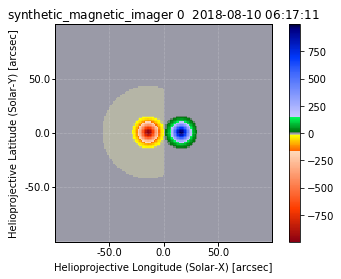

In [205]:
magnetogram.peek(cmap='hmimag')

In [206]:
shape_z = 150 * u.pixel
width_z = (magnetogram.scale.axis1 * shape_z).to(u.radian).value * magnetogram.dsun

In [207]:
extrapolator = synthesizAR.extrapolate.PotentialField(magnetogram, width_z, shape_z)
B_field = extrapolator.extrapolate()

In [271]:
fieldlines = extrapolator.trace_fieldlines(B_field, 200,
                                           loop_length_range=[10,100]*u.Mm,
                                           mask_threshold=0.1,
                                           close_threshold=0.01)

yt : [INFO     ] 2018-08-10 01:41:11,761 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-08-10 01:41:11,762 Parameters: domain_dimensions         = [150 150 150]
yt : [INFO     ] 2018-08-10 01:41:11,765 Parameters: domain_left_edge          = [-7.21882304e+09 -7.21881958e+09  0.00000000e+00]
yt : [INFO     ] 2018-08-10 01:41:11,767 Parameters: domain_right_edge         = [7.21987984e+09 7.21987638e+09 1.45054189e+10]
yt : [INFO     ] 2018-08-10 01:41:11,770 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2018-08-10 01:41:13,215 AMRKDTree rebuilt, Final Volume: 3.024032e+30
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 301.88it/s]
yt : [INFO     ] 2018-08-10 01:41:14,885 AMRKDTree rebuilt, Final Volume: 3.024032e+30
Streamlining: 100%|██████████| 65/65 [00:00<00:00, 294.88it/s]
yt : [INFO     ] 2018-08-10 01:41:15,931 AMRKDTree rebuilt, Final Volume: 3.024032e+30
Streamlining: 100%|██████████| 25/25 [00:00<00:00, 221.67it/s]
yt : [INFO     ] 2018-08

FloatProgress(value=0.0)

In [272]:
active_region = synthesizAR.Field(magnetogram, fieldlines)

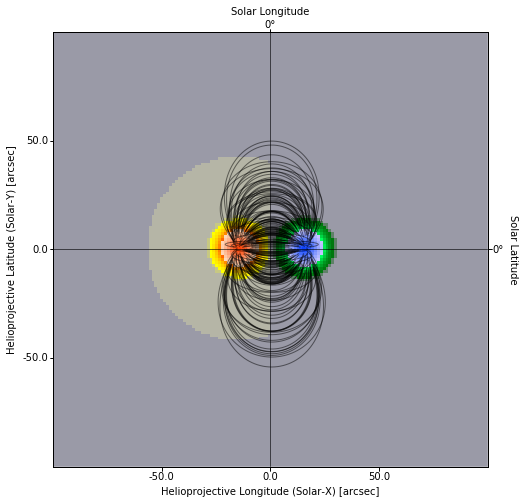

In [273]:
active_region.peek(line_frequency=1)

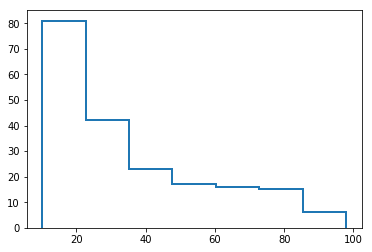

In [274]:
plt.hist([loop.full_length.to(u.Mm).value for loop in active_region.loops], histtype='step', lw=2, bins='scott');

In [82]:
loop = active_region.loops[0]

In [83]:
#i_apex = np.where(loop.field_aligned_coordinate>=loop.full_length/2.)[0][0]#loop.coordinates.spherical.distance.argmax()
i_apex = loop.coordinates.spherical.distance.argmax()

In [84]:
ms = MartensScalingLaws(loop.field_aligned_coordinate[:(i_apex+1)],
                        loop.field_aligned_coordinate[i_apex],4*u.MK,)

In [85]:
t = ms.temperature
n = ms.density

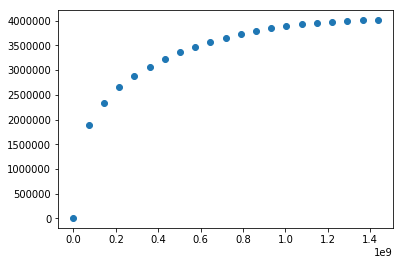

In [86]:
plt.plot(loop.field_aligned_coordinate[:(i_apex+1)],t,marker='o',ls='')

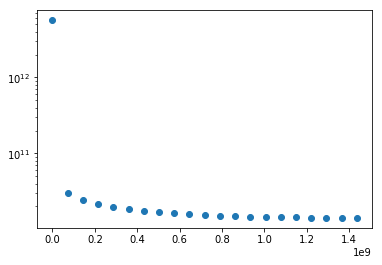

In [87]:
plt.plot(loop.field_aligned_coordinate[:(i_apex+1)],n,marker='o',ls='')
plt.yscale('log')

In [29]:
((loop.field_strength.mean()*0.3)**2)/(8.*np.pi)/((1*u.day).to(u.s))

<Quantity 0.00037658 G2 / s>

In [88]:
s_other = ((loop.coordinates.spherical.distance[(i_apex+1):][::-1] - const.R_sun)
 /(loop.coordinates.spherical.distance[i_apex] - const.R_sun)) * loop.field_aligned_coordinate[i_apex]

In [ ]:
s_other = 

In [89]:
ms_other = MartensScalingLaws(s_other,loop.field_aligned_coordinate[i_apex],
                              4*u.MK)

In [90]:
t_other = ms_other.temperature
n_other = ms_other.density

In [91]:
t_full = u.Quantity(np.concatenate([t.value,t_other[::-1].value]),t.unit)
n_full = u.Quantity(np.concatenate([n.value,n_other[::-1].value]),n.unit)

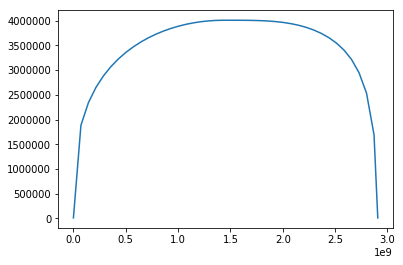

In [92]:
plt.plot(loop.field_aligned_coordinate,t_full)

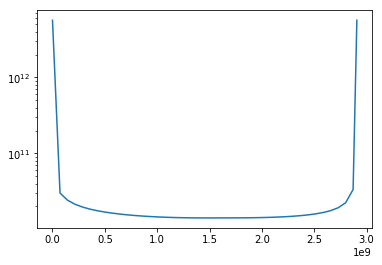

In [93]:
plt.plot(loop.field_aligned_coordinate,n_full)
plt.yscale('log')

In [95]:
t_full.shape

(42,)

In [96]:
loop.field_aligned_coordinate.shape

(42,)

In [213]:
class MartensInterface(object):
    
    @u.quantity_input
    def __init__(self, base_temperature=0.01*u.MK, alpha=0, gamma=0.5):
        self.base_temperature = base_temperature
        self.alpha = alpha
        self.gamma = gamma
        
    def get_max_temperature(self, loop):
        B_mean = loop.field_strength.mean().to(u.Gauss).value
        energy = ((0.3*B_mean)**2)/(8*np.pi)*u.erg/(u.cm**3)
        rate = energy/(1*u.day)
        rate = rate.to(u.erg/u.s/(u.cm**3)).value
        # Use RTV to get max temperature
        L = loop.full_length.to(u.cm).value/2.
        return (1.4e3)/((9.8e4)**(2/7)) * (rate**(2/7)) * (L**(4/7)) * u.K
        
    def load_results(self,loop):
        i_apex = loop.coordinates.spherical.distance.argmax()
        half_length = loop.field_aligned_coordinate[i_apex]
        Tmax = self.get_max_temperature(loop)
        # First Half
        s_half1 = loop.field_aligned_coordinate[:(i_apex+1)]
        ms = MartensScalingLaws(s_half1, half_length, Tmax,
                                alpha=self.alpha, gamma=self.gamma,
                                base_temperature=self.base_temperature)
        T_half1 = ms.temperature
        n_half1 = ms.density
        # Second Half
        r = loop.coordinates.spherical.distance
        s_half2 = ((r[(i_apex+1):][::-1] - const.R_sun)/(r[i_apex] - const.R_sun)) * half_length
        ms = MartensScalingLaws(s_half2, half_length, Tmax,
                                alpha=self.alpha, gamma=self.gamma,
                                base_temperature=self.base_temperature)
        T_half2 = ms.temperature
        n_half2 = ms.density
        # Combine
        T = u.Quantity(np.concatenate([T_half1.value, T_half2.value[::-1]]), T_half1.unit)
        T = T[np.newaxis, :]
        n = u.Quantity(np.concatenate([n_half1.value, n_half2.value[::-1]]), n_half1.unit)
        n = n[np.newaxis, :]
        
        return [0.,]*u.s, T, T, n, np.zeros(T.shape)*u.cm/u.s

In [275]:
minterface = MartensInterface()
#t,Te,Ti,n,v = minterface.load_results(active_region.loops[0])

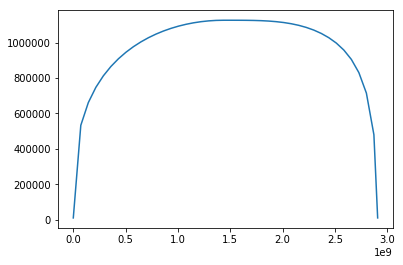

In [111]:
plt.plot(active_region.loops[0].field_aligned_coordinate,Te[0,:])

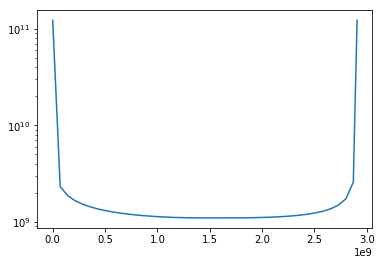

In [113]:
plt.plot(active_region.loops[0].field_aligned_coordinate,n[0,:])
plt.yscale('log')

In [281]:
active_region.load_loop_simulations(minterface,'martens_parameters.h5',)

FloatProgress(value=0.0)

In [290]:
aia = InstrumentSDOAIA([0,1]*u.s,
                       SkyCoord(lon=0*u.deg, lat=-90*u.deg, radius=const.au, frame='heliographic_stonyhurst'),)

In [291]:
obs = synthesizAR.Observer(active_region, [aia], parallel=False)

In [292]:
obs.build_detector_files('.',0.25*u.Mm)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [285]:
obs.flatten_detector_counts()

In [293]:
obs.bin_detector_counts('.')

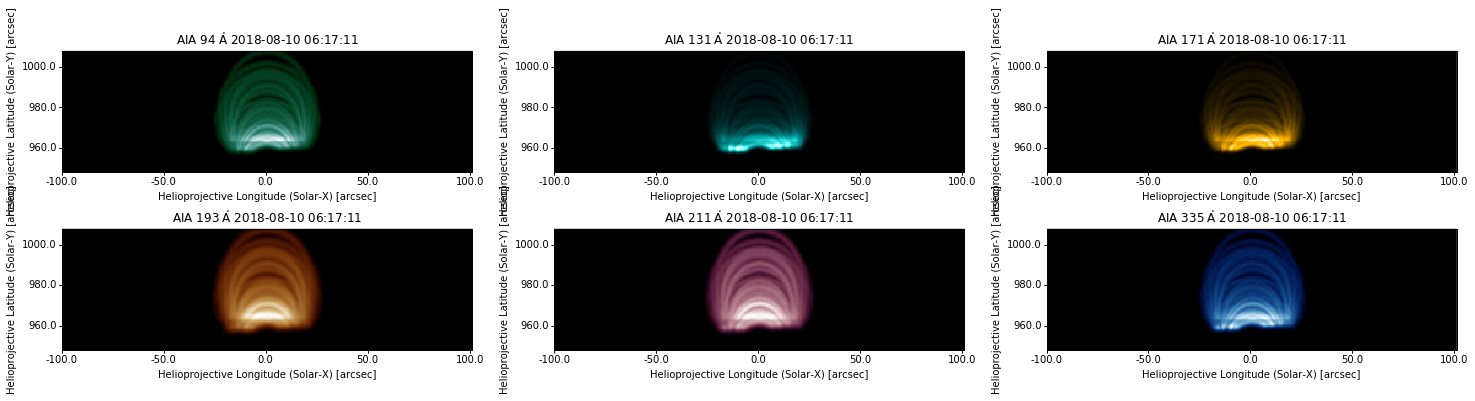

In [297]:
fig = plt.figure(figsize=(25,6))
for i,c in enumerate(aia.channels):
    m = Map(f'SDO_AIA/{c["name"]}/map_t000000.fits')
    ax = fig.add_subplot(2,3,i+1,projection=m,)
    m.plot(axes=ax, norm=ImageNormalize(vmin=0.,vmax=m.data.max(),stretch=SqrtStretch()))
    # m.draw_grid(axes=ax)
    ax.grid(alpha=0)

In [299]:
for loop in active_region.loops:
    if loop.full_length > 90*u.Mm:
        print(loop.name)

loop000022
loop000038
loop000111
loop000125


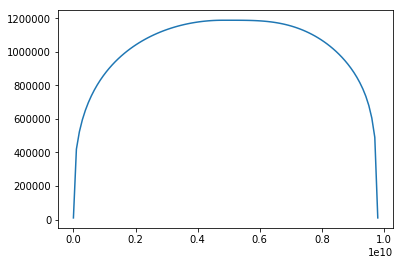

In [303]:
plt.plot(active_region.loops[125].field_aligned_coordinate,
         active_region.loops[125].electron_temperature[0,:])

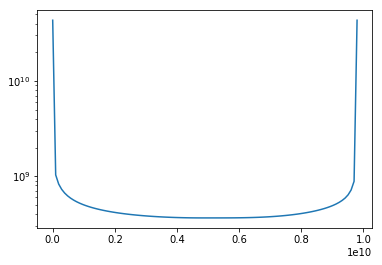

In [306]:
plt.plot(active_region.loops[125].field_aligned_coordinate,
         active_region.loops[125].density[0,:])
plt.yscale('log')